In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed

from sklearn.metrics import roc_auc_score, roc_curve, auc

import rnn

/software/python-3.6.1-el7-x86_64+intel-16.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def flexroc(fname):
    
    """
    Run the flexroc binary to get flexible AUC scores.
    Return a dictionary in with keys: 
        lat1, lat2, lon1, lon2, 
        VAR, 
        HOMICIDE-ASSAULT-BATTERY,
        BURGLARY-THEFT-MOTOR_VEHICLE_THEFT
    """
    
    FLEXROC = '/home/yhuang10/Spatio-Temporal/cynet_/bin/flexroc '
    
    RES = {}
    
    h = np.array(fname.split('/')[-1].split('_')[0].split('#')).astype(float)
    RES['lat1'], RES['lat2'], RES['lon1'], RES['lon2'] = h 
    df = pd.read_csv(fname)

    df[['AR_grt','AR_prd']].to_csv('tmp.csv', header=None, index=None, sep=' ')

    result = ! $FLEXROC -i tmp.csv -w 1 -x 0 -t 0.8 -f 0.2 -E 0 -C 1 -L 1
    RES['VAR'] = float(result[0].split()[1])
    
    df[['AS_grt','AS_prd']].to_csv('tmp.csv', header=None, index=None, sep=' ')
    result = ! $FLEXROC -i tmp.csv -w 1 -x 0 -t 0.8 -f 0.2 -E 0 -C 1 -L 1
    RES['HOMICIDE-ASSAULT-BATTERY'] = float(result[0].split()[1])
    
    df[['PR_grt','PR_prd']].to_csv('tmp.csv',header=None,index=None,sep=' ')
    result = ! $FLEXROC -i tmp.csv -w 1 -x 0 -t 0.8 -f 0.2 -E 0 -C 1 -L 1
    RES['BURGLARY-THEFT-MOTOR_VEHICLE_THEFT'] = float(result[0].split()[1])

    ! rm tmp.csv
    
    return RES

In [3]:
meta = pd.read_csv('../data/meta.csv', index_col=0)
X_raw = np.genfromtxt('../data/CRIME-_2014-01-01_2016-12-31.csv')

## Average Performance:
Test the performance of (deep) RNN with horizon=$7$ on the $50$ blocks.
- We run 10 here and try the others using slurm. 

In [5]:
random = [ 
    298, 304, 908, 1176, 453,  
    281, 947, 203, 1443, 159]  
#     870, 109, 103, 1206, 1084, 
#     615, 1013, 324, 470, 901,
#     1025, 260, 1106, 551, 82, 
#     903, 1137, 1477, 210, 388,
#     824, 270,  595, 269, 454,
#     291, 637, 930, 292, 360,
#     832, 29, 320, 498, 1181, 
#     1352, 732, 1164, 488, 1124]

In [ ]:
future = 7
RES = []
for r in random:
    center = meta.index[r]

    tile = meta.loc[center, ['lat1', 'lat2','lon1', 'lon2']]

    X_train, Y_train, X_test, Y_test = rnn.getData(meta, X_raw, center, future)

    model = rnn.train_3(X_train, Y_train, epochs=200)
    prediction = model.predict(X_test)
    
    figTitle = 'results/random_500-100-10_200/' + '#'.join(map(str, tile.values)) + '_{}'.format(future)
    dfName = figTitle + '.rnnres'
    rnn.Analysis(Y_test, prediction, figTitle, dfName)
    rnnres = flexroc(dfName)
    RES.append(rnnres)

Arrest: 389,
Property: 2728,
Assault: 4976.
Training data: input dim = (1, 723, 6165), output dim = (1, 723, 3)
Out-sample data: input dim = (1, 366, 6165), output dim = (1, 366, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 500)         13332000  
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         240400    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 10)          4440      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 3)           33        
Total params: 13,576,873
Trainable params: 13,576,873
Non-trainable params: 0
_________________________________________________________________
Train on 1 samples
Epoch 1/200
1/1 [========================

In [39]:
cynet = pd.read_csv('../data/cynet_performance.csv').round(4)
rnn = pd.DataFrame(data=RES)
rnn = rnn.set_index(['lat1','lat2','lon1','lon2']).stack().reset_index().rename(columns={'level_4':'var',0:'auc_NN'}).round(4)
df = cynet.set_index(['lat1','lat2','lon1','lon2','var']).join(rnn.set_index(['lat1','lat2','lon1','lon2','var'])).reset_index().dropna()
df

,lat1,lat2,lon1,lon2,var,auc,auc_NN
963,41.7570,41.7598,-87.6573,-87.6538,BURGLARY-THEFT-MOTOR_VEHICLE_THEFT,0.9524,0.7106
964,41.7570,41.7598,-87.6573,-87.6538,HOMICIDE-ASSAULT-BATTERY,0.9898,0.8480
965,41.7570,41.7598,-87.6573,-87.6538,VAR,0.8767,0.7228
3524,41.8814,41.8842,-87.7452,-87.7417,BURGLARY-THEFT-MOTOR_VEHICLE_THEFT,0.9553,0.7827
3525,41.8814,41.8842,-87.7452,-87.7417,HOMICIDE-ASSAULT-BATTERY,0.9694,0.7642
3526,41.8814,41.8842,-87.7452,-87.7417,VAR,0.8968,0.7718


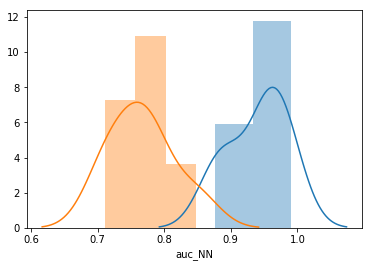

In [43]:
sns.distplot(df.auc)
sns.distplot(df.auc_NN)
plt.show()